/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU: True


100%|███████████████████████████████| 20000/20000 [04:30<00:00, 74.03it/s, Iter=2e+4, Loss=1.18e+00]


Adam done!
Test_L2error: 1.22e-01
Training time: 270.16
[]


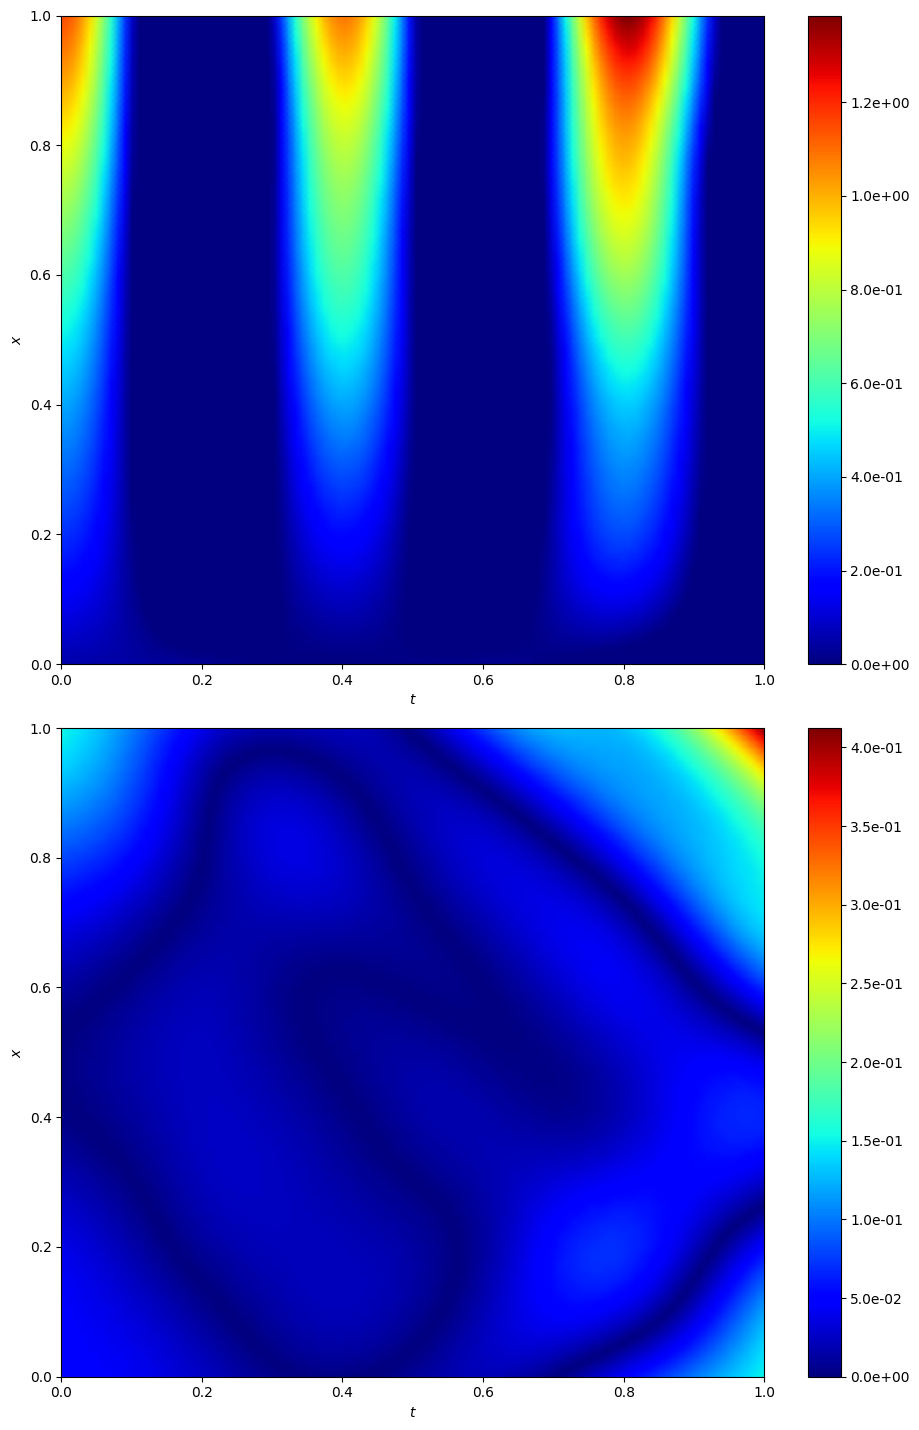

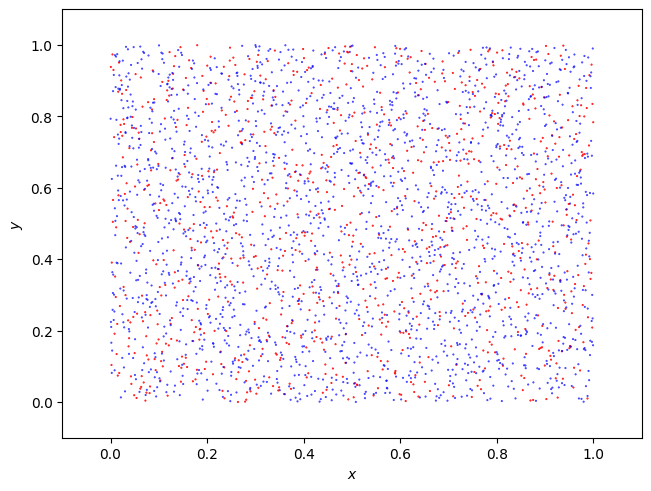

In [1]:
import os
import time
import numpy as np
import torch
from matplotlib import pyplot as plt, gridspec
from torch import nn
from torch.autograd import Variable
from tqdm import tqdm, trange
from pyDOE import lhs
from collections import OrderedDict
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
device = torch.device('cuda')
use_gpu = torch.cuda.is_available()
print('GPU:', use_gpu)


def random_fun(num):
    temp = torch.from_numpy(lb + (ub - lb) * lhs(2, num)).float()
    if use_gpu:
        temp = temp.cuda()
    return temp


def is_cuda(data):
    if use_gpu:
        data = data.cuda()
    return data



class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.iter = 0
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a



class Model:
    def __init__(self, net, x_bc,
                 u_bc,
                 x_ic,
                 u_ic, x_f_loss_fun,
                 x_test, x_test_exact
                 ):

        self.x_ic_s = None
        self.x_bc_s = None
        self.x_ict_s = None
        self.x_f_s = None
        self.s_collect = []

        self.optimizer_LBGFS = None
        self.net = net

        self.x_bc = x_bc
        self.u_bc = u_bc

        self.x_ic = x_ic
        self.u_ic = u_ic

        self.x_f_N = None
        self.x_f_M = None

        self.x_f_loss_fun = x_f_loss_fun

        self.x_test = x_test
        self.x_test_exact = x_test_exact

        self.start_loss_collect = False
        self.x_label_loss_collect = []
        self.x_f_loss_collect = []
        self.x_test_estimate_collect = []

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_e, loss_ic, loss_bc, loss_u0t):
        loss = torch.exp(-self.x_f_s) * loss_e.detach() + self.x_f_s \
               + torch.exp(-self.x_ic_s) * loss_ic.detach() + self.x_ic_s \
               + torch.exp(-self.x_bc_s) * loss_bc.detach() + self.x_bc_s \
               + torch.exp(-self.x_ict_s) * loss_u0t.detach() + self.x_ict_s
        return loss

    def true_loss(self, loss_e, loss_ic, loss_bc, loss_u0t):
        return torch.exp(-self.x_f_s.detach()) * loss_e + torch.exp(-self.x_ic_s.detach()) * loss_ic + torch.exp(
            -self.x_bc_s.detach()) * loss_bc + torch.exp(
            -self.x_ict_s.detach()) * loss_u0t

    # computer backward loss
    def epoch_loss(self):
        x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        loss_equation = torch.mean(self.x_f_loss_fun(x_f, self.train_U) ** 2)

        loss_ic = torch.mean((self.train_U(self.x_ic) - self.u_ic) ** 2)

        loss_bc = torch.mean((self.train_U(self.x_bc) - self.u_bc) ** 2)

        x = Variable(self.x_ic, requires_grad=True)
        u0 = self.train_U(x)
        d = torch.autograd.grad(u0, x, grad_outputs=torch.ones_like(u0), create_graph=True)
        u0_t = d[0][:, 0].unsqueeze(-1)
        loss_u0t = torch.mean(u0_t ** 2)

        # if self.start_loss_collect:
        #     self.x_f_loss_collect.append([self.net.iter, loss_equation.item()])
        #     self.x_label_loss_collect.append([self.net.iter, loss_label.item()])
        return loss_equation, loss_ic, loss_bc, loss_u0t

    # computer backward loss
    def LBGFS_epoch_loss(self):
        self.optimizer_LBGFS.zero_grad()
        x_f = torch.cat((self.x_f_N, self.x_f_M), dim=0)
        loss_equation = torch.mean(self.x_f_loss_fun(x_f, self.train_U) ** 2)

        loss_ic = torch.mean((self.train_U(self.x_ic) - self.u_ic) ** 2)

        loss_bc = torch.mean((self.train_U(self.x_bc) - self.u_bc) ** 2)

        x = Variable(self.x_ic, requires_grad=True)
        u0 = self.train_U(x)
        d = torch.autograd.grad(u0, x, grad_outputs=torch.ones_like(u0), create_graph=True)
        u0_t = d[0][:, 0].unsqueeze(-1)
        loss_u0t = torch.mean(u0_t ** 2)

        # if self.start_loss_collect:
        #     self.x_f_loss_collect.append([self.net.iter, loss_equation.item()])
        #     self.x_label_loss_collect.append([self.net.iter, loss_label.item()])

        loss = self.true_loss(loss_equation, loss_ic, loss_bc, loss_u0t)
        loss.backward()
        self.net.iter += 1
        if self.net.iter % 1000 == 0:
            print('Iter:', self.net.iter, 'Loss:', loss.item())
        #print('Iter:', self.net.iter, 'Loss:', loss.item())
        return loss

    def evaluate(self):
        pred = self.train_U(self.x_test).cpu().detach().numpy()
        exact = self.x_test_exact.cpu().detach().numpy()
        error = np.linalg.norm(pred - exact, 2) / np.linalg.norm(exact, 2)
        return error

    def run_baseline(self):
        optimizer_adam = torch.optim.Adam(self.net.parameters(), lr=adam_lr)
        self.optimizer_LBGFS = torch.optim.LBFGS(self.net.parameters(), lr=lbgfs_lr,
                                                 max_iter=lbgfs_iter)
        pbar = trange(adam_iter, ncols=100)
        for i in pbar:
            optimizer_adam.zero_grad()
            loss_e, loss_ic, loss_bc, loss_u0t = self.epoch_loss()
            loss = self.true_loss(loss_e, loss_ic, loss_bc, loss_u0t)
            loss.backward()
            optimizer_adam.step()
            self.net.iter += 1
            pbar.set_postfix({'Iter': self.net.iter,
                              'Loss': '{0:.2e}'.format(loss.item())
                              })

        print('Adam done!')
        #self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
        #print('LBGFS done!')

        error = self.evaluate()
        print('Test_L2error:', '{0:.2e}'.format(error))

    def run_AM(self):
        for move_count in range(AM_count):
            # if move_count < 1:
            #     lbgfs_iter= 2000
            # elif  move_count > 1:
            #     lbgfs_iter= 10000
            self.optimizer_LBGFS = torch.optim.LBFGS(self.net.parameters(), lr=lbgfs_lr,
                                                     max_iter=lbgfs_iter)
            optimizer_adam = torch.optim.Adam(self.net.parameters(), lr=adam_lr)
            pbar = trange(adam_iter, ncols=100)

            for i in pbar:
                optimizer_adam.zero_grad()
                loss_e, loss_ic, loss_bc, loss_u0t = self.epoch_loss()
                loss = self.true_loss(loss_e, loss_ic, loss_bc, loss_u0t)
                loss.backward()
                self.net.iter += 1
                optimizer_adam.step()
                pbar.set_postfix({'Iter': self.net.iter,
                                  'Loss': '{0:.2e}'.format(loss.item())
                                  })

            print('Adam done!')
            # if move_count == AM_count-1:
            #     self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
            #     print('LBGFS done!')
            self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
            print('LBGFS done!')

            error = self.evaluate()
            print('change_counts', move_count, 'Test_L2error:', '{0:.2e}'.format(error))
            self.x_test_estimate_collect.append([move_count, '{0:.2e}'.format(error)])
           # if move_count > 0:
            if AM_type == 0:
                x_init = random_fun(100000)
                x_init_residual = abs(self.x_f_loss_fun(x_init, self.train_U))
                x_init_residual = x_init_residual.cpu().detach().numpy()
                err_eq = np.power(x_init_residual, AM_K) / np.power(x_init_residual, AM_K).mean()
                err_eq_normalized = (err_eq / sum(err_eq))[:, 0]
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=err_eq_normalized)
                self.x_f_M = x_init[X_ids]

            elif AM_type == 1:
                x_init = random_fun(100000)
                x = Variable(x_init, requires_grad=True)
                u = self.train_U(x)
                dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
                grad_x1 = dx[:, [0]].squeeze()
                grad_x2 = dx[:, [1]].squeeze()
                dx = torch.sqrt(1 + grad_x1 ** 2 + grad_x2 ** 2).cpu().detach().numpy()
                err_dx = np.power(dx, AM_K) / np.power(dx, AM_K).mean()
                p = (err_dx / sum(err_dx))
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=p)
                self.x_f_M = x_init[X_ids]

    def run_AM_AW1(self):
        self.x_f_s = nn.Parameter(self.x_f_s, requires_grad=True)
        self.x_ic_s = nn.Parameter(self.x_ic_s, requires_grad=True)
        self.x_bc_s = nn.Parameter(self.x_bc_s, requires_grad=True)
        self.x_ict_s = nn.Parameter(self.x_ict_s, requires_grad=True)

        for move_count in range(AM_count):
            self.optimizer_LBGFS = torch.optim.LBFGS(self.net.parameters(), lr=lbgfs_lr,
                                                     max_iter=lbgfs_iter)
            optimizer_adam = torch.optim.Adam(self.net.parameters(), lr=adam_lr)
            optimizer_adam_weight = torch.optim.Adam([self.x_f_s] + [self.x_ic_s] + [self.x_bc_s] + [self.x_ict_s],
                                                     lr=AW_lr)

            pbar = trange(adam_iter, ncols=100)
            for i in pbar:
                self.s_collect.append([self.net.iter, self.x_f_s.item(), self.x_ic_s.item(), self.x_bc_s.item(),self.x_ict_s.item()])

                loss_e, loss_ic, loss_bc, loss_u0t = self.epoch_loss()

                optimizer_adam.zero_grad()
                loss = self.true_loss(loss_e, loss_ic, loss_bc, loss_u0t)
                loss.backward()
                optimizer_adam.step()
                self.net.iter += 1
                pbar.set_postfix({'Iter': self.net.iter,
                                  'Loss': '{0:.2e}'.format(loss.item())
                                  })

                optimizer_adam_weight.zero_grad()
                loss = self.likelihood_loss(loss_e, loss_ic, loss_bc, loss_u0t)
                loss.backward()
                optimizer_adam_weight.step()

            print('Adam done!')
            self.optimizer_LBGFS.step(self.LBGFS_epoch_loss)
            print('LBGFS done!')

            error = self.evaluate()
            print('change_counts', move_count, 'Test_L2error:', '{0:.2e}'.format(error))
            self.x_test_estimate_collect.append([move_count, '{0:.2e}'.format(error)])

            if AM_type == 0:
                x_init = random_fun(100000)
                x_init_residual = abs(self.x_f_loss_fun(x_init, self.train_U))
                x_init_residual = x_init_residual.cpu().detach().numpy()
                err_eq = np.power(x_init_residual, AM_K) / np.power(x_init_residual, AM_K).mean()
                err_eq_normalized = (err_eq / sum(err_eq))[:, 0]
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=err_eq_normalized)
                self.x_f_M = x_init[X_ids]

            elif AM_type == 1:
                x_init = random_fun(100000)
                x = Variable(x_init, requires_grad=True)
                u = self.train_U(x)
                dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
                grad_x1 = dx[:, [0]].squeeze()
                grad_x2 = dx[:, [1]].squeeze()
                dx = torch.sqrt(1 + grad_x1 ** 2 + grad_x2 ** 2).cpu().detach().numpy()
                err_dx = np.power(dx, AM_K) / np.power(dx, AM_K).mean()
                p = (err_dx / sum(err_dx))
                X_ids = np.random.choice(a=len(x_init), size=M, replace=False, p=p)
                self.x_f_M = x_init[X_ids]

    def train(self):

        self.x_f_N = random_fun(N)
        self.x_f_M = random_fun(M)

        # self.x_f_s = is_cuda(-torch.log(torch.tensor(1.).float()))
        # self.x_label_s = is_cuda(
        #     -torch.log(torch.tensor(100.).float()))  # 0.5*torch.exp(-self.x_label_s.detach()) = 100

        self.x_f_s = is_cuda(torch.tensor(0.).float())
        self.x_ic_s = is_cuda(torch.tensor(0.).float())
        self.x_bc_s = is_cuda(torch.tensor(0.).float())
        self.x_ict_s = is_cuda(torch.tensor(0.).float())

        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AM()
        elif model_type == 2:
            self.run_AM_AW1()
        elapsed = time.time() - start_time
        print('Training time: %.2f' % elapsed)


def U_tt(x, t):
    return - 25 * torch.pi ** 2 * x * torch.cos(5 * torch.pi * t) + 6 * t * x ** 3


def U_xx(x, t):
    return 6 * x * t ** 3


def PDE_f1(x, t):
    return U_tt(x, t) + a * U_xx(x, t) + b * PDE_u(x, t) + c * PDE_u(x, t) ** k


def PDE_u(x, t):
    return x * torch.cos(5 * torch.pi * t) + (x * t) ** 3


def x_f_loss_fun(x, train_U):
    if not x.requires_grad:
        x = Variable(x, requires_grad=True)
    u = train_U(x)
    d = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)
    u_t = d[0][:, 0].unsqueeze(-1)
    u_x = d[0][:, 1].unsqueeze(-1)
    u_tt = torch.autograd.grad(u_t, x, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, [0]]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, [1]]
    t = x[:, [0]]
    x1 = x[:, [1]]
    f = u_tt + a * u_xx + b * u + c * u ** k - (
        PDE_f1(x1, t)
    )
    return f


def draw_exact():
    predict_np = model.predict_U(x_test).cpu().detach().numpy()
    u_test_np = x_test_exact.cpu().detach().numpy()
    u_test = x_test_exact.cpu().detach().numpy()
    TT, XX = np.meshgrid(t, x)
    fig = plt.figure(figsize=(9.6, 14.4))  
    plt.subplot(2, 1, 1)  # 1行2列，第1个位置
    e = np.reshape(predict_np, (TT.shape[0], TT.shape[1]))
    plot = plt.pcolormesh(TT, XX, e, shading='gouraud', cmap='jet', vmin=0, vmax=np.max(e))
    plt.colorbar(plot, format="%1.1e")
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    #plt.title(r'Exact $u(t,x)$', fontsize=20)
    # plt.tight_layout()
    # plt.savefig('burgers_exact.pdf')
    # plt.show()
    plt.subplot(2, 1, 2)  # 1行2列，第2个位置
    e = np.reshape(abs(predict_np - u_test), (TT.shape[0], TT.shape[1]))
    plot = plt.pcolormesh(TT, XX, e, shading='gouraud', cmap='jet', vmin=0, vmax=np.max(e))
    plt.colorbar(plot, format="%1.1e")
    plt.xlabel('$t$')
    plt.ylabel('$x$')
    #plt.title(r'WAM-AW $u(t,x)$', fontsize=20)
    plt.tight_layout()
    plt.savefig('Kel_pred_and_error_PINN.pdf')
    plt.show()



def draw_points(points,N_points=None):
    points = points.cpu().detach().numpy()
    points_bc = x_bc.cpu().detach().numpy()
    if N_points is not None:
        adds = N_points.cpu().detach().numpy()
        #plt.plot(adds[:, [0]], adds[:, [1]], 'kx', markersize=4)
    fig, ax = plt.subplots(layout='constrained', figsize=(6.4, 4.8))
    xs, xe, ys, ye = lb[0], ub[0], lb[1], ub[1]
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.scatter(points[:, 0], points[:, 1], c='r', marker='.', s=np.ones_like(points[:, 0]), alpha=1.0)
    ax.scatter(adds[:, 0], adds[:, 1], c='b', marker='.', s=np.ones_like(adds[:, 0]), alpha=0.8)
    #ax.scatter(points_bc[:, 0], points_bc[:, 1], c='b', marker='.', s=np.ones_like(points_bc[:, 0]), alpha=0.3)
    #ax.legend(loc='upper right', fontsize=12)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plt.savefig('Kel-GAD.pdf')
    plt.show()    


def draw_residual():
    f = x_f_loss_fun(x_test, model.train_U)
    f = f.cpu().detach().numpy()
    XX1, XX2 = np.meshgrid(t, x)
    e = np.reshape(abs(f), (XX1.shape[0], XX1.shape[1]))
    plt.pcolor(XX1, XX2, e, shading='auto', cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('$x$', fontsize=20)
    plt.title('$Residual$', fontsize=20)
    plt.tight_layout()
    plt.savefig('KG_residual-WAM-AW.pdf')
    plt.show()


def draw_error():
    predict_np = model.predict_U(x_test).cpu().detach().numpy()
    u_test = x_test_exact.cpu().detach().numpy()
    XX1, XX2 = np.meshgrid(t, x)
    e = np.reshape(abs(predict_np - u_test), (XX1.shape[0], XX1.shape[1]))
    plt.pcolor(XX1, XX2, e, shading='auto', cmap='jet')
    plt.colorbar()
    plt.xlabel('$t$', fontsize=20)
    plt.ylabel('$x$', fontsize=20)
    plt.title('$Error$', fontsize=20)
    plt.tight_layout()
    plt.savefig('KG_error-WAM-AW.pdf')
    plt.show()


def draw_epoch_loss():
    x_label_loss_collect = np.array(model.x_label_loss_collect)
    x_f_loss_collect = np.array(model.x_f_loss_collect)
    plt.subplot(2, 1, 1)
    plt.yscale('log')
    plt.plot(x_label_loss_collect[:, 0], x_label_loss_collect[:, 1], 'b-', label='Label_loss')
    plt.xlabel('$Epoch$')
    plt.ylabel('$Loss$')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.yscale('log')
    plt.plot(x_f_loss_collect[:, 0], x_f_loss_collect[:, 1], 'r-', label='PDE_loss')
    plt.xlabel('$Epoch$')
    plt.ylabel('$Loss$')
    plt.legend()
    plt.show()


def draw_epoch_w():
    s_collect = np.array(model.s_collect)
    np.savetxt('s_WAM-AW.npy', s_collect)
    plt.rc('legend', fontsize=16)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 1]), 'b-', label='$e^{-s_{r}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 2]), 'r-', label='$e^{-s_{i}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 3]), 'g-', label='$e^{-s_{b}}$')
    plt.plot(s_collect[:, 0], np.exp(-s_collect[:, 4]), 'y-', label='$e^{-s_{it}}$')
    plt.xlabel('$Iters$', fontsize=20)
    plt.ylabel('$\lambda$', fontsize=20)
    plt.legend()
    plt.savefig('KG_S_WAM-AW.pdf', fontsize=20)
    plt.show()




def draw_some_t():
    predict_np = model.predict_U(x_test).cpu().detach().numpy()
    u_test_np = x_test_exact.cpu().detach().numpy()
    TT, XX = np.meshgrid(t, x)
    u_pred = np.reshape(predict_np, (TT.shape[0], TT.shape[1]))
    u_test = np.reshape(u_test_np, (TT.shape[0], TT.shape[1]))
    gs1 = gridspec.GridSpec(2, 2)
    # gs1.update(top=0.9, bottom=0.1, left=0.1, right=0.9, wspace=0.8)
    ax = plt.subplot(gs1[0, 0])
    plt.rc('legend', fontsize=16)
    ax.plot(x, u_test.T[0, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, u_pred.T[0, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$u(x,t)$', fontsize=20)
    ax.set_title('$t = %.2f$' % (t[0]), fontsize=20)

    ax.set_xlim([-0.1, 1.1])
    ax.axis('square')

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x, u_test.T[25, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, u_pred.T[25, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$u(x,t)$', fontsize=20)
    ax.set_xlim([-0.1, 1.1])
    ax.axis('square')
    ax.set_title('$t = %.2f$' % (t[25]), fontsize=20)

    ax = plt.subplot(gs1[1, 0])
    ax.plot(x, u_test.T[50, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, u_pred.T[50, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$u(x,t)$', fontsize=20)
    ax.set_xlim([-0.1, 1.1])
    ax.axis('square')
    ax.set_title('$t = %.2f$' % (t[50]), fontsize=20)

    ax = plt.subplot(gs1[1, 1])
    ax.plot(x, u_test.T[-1, :], 'b-', linewidth=2, label='Exact')
    ax.plot(x, u_pred.T[-1, :], 'r--', linewidth=2, label='Prediction')
    ax.set_xlabel('$x$', fontsize=20)
    ax.set_ylabel('$u(x,t)$', fontsize=20)
    ax.axis('square')
    ax.set_xlim([-0.1, 1.1])
    ax.set_title('$t = %.2f$' % (t[-1]), fontsize=20)
    plt.tight_layout()
    plt.savefig('KG_qie_WAM-AW.pdf')
    plt.show()


if __name__ == '__main__':
    lb = np.array([0.0, 0.0])
    ub = np.array([1.0, 1.0])

    layers = [2, 200, 200, 200, 200,200, 1]
    #layers = [2, 125, 200, 100, 100, 80,1]
    net = is_cuda(Net(layers))

    N = 2000
    M = 1000
    Nbc = 100
    Nic = 100

    adam_iter, lbgfs_iter = 20000, 10000
    adam_lr, lbgfs_lr = 0.001, 0.8

    model_type =0 # 0:baseline  1:AM  2:AM_AW

    AM_type = 1  # 0:RAM  1:WAM
    AM_K = 1
    AM_count = 10

    AW_lr = 0.001

    # test data
    k = 3
    a = -1
    b = 0
    c = 1

    exact_u = lambda x: x[:, [1]] * np.cos(5 * np.pi * x[:, [0]]) + np.power(x[:, [1]] * x[:, [0]], 3)

    t = np.expand_dims(np.linspace(0, 1, 100), axis=1)
    x = np.expand_dims(np.linspace(0, 1, 100), axis=1)
    X1, X2 = np.meshgrid(t, x)

    x_test_np = np.concatenate((np.vstack(np.expand_dims(X1, axis=2)), np.vstack(np.expand_dims(X2, axis=2))), axis=-1)
    solution = exact_u(x_test_np)
    x_test = is_cuda(torch.from_numpy(x_test_np).float())
    x_test_exact = is_cuda(torch.from_numpy(solution).float())

    # ic bc data
    x_init = torch.from_numpy(x).float()
    x_initial = torch.cat((torch.zeros(Nic, 1), x_init), dim=1)
    x_boundary_left = torch.cat((torch.rand([Nbc, 1]), torch.full([Nbc, 1], 0)), dim=1)
    x_boundary_right = torch.cat((torch.rand([Nbc, 1]), torch.ones([Nbc, 1])), dim=1)

    x_initial_label = torch.from_numpy(exact_u(x_initial.numpy())).float()
    x_boundary_left_label = torch.from_numpy(exact_u(x_boundary_left.numpy())).float()
    x_boundary_right_label = torch.from_numpy(exact_u(x_boundary_right.numpy())).float()

    x_ic = is_cuda(x_initial)
    u_ic = is_cuda(x_initial_label)
    x_bc = is_cuda(torch.cat((x_boundary_left, x_boundary_right), dim=0))
    u_bc = is_cuda(torch.cat((x_boundary_left_label, x_boundary_right_label), dim=0))

    model = Model(
        net=net,
        x_bc=x_bc,
        u_bc=u_bc,
        x_ic=x_ic,
        u_ic=u_ic,
        x_f_loss_fun=x_f_loss_fun,
        x_test=x_test,
        x_test_exact=x_test_exact,
    )
    model.train()
    print(model.x_test_estimate_collect)

    draw_exact()
    draw_points(model.x_f_M,N_points=model.x_f_N)
    
    # # draw_exact_points(model.x_f_M, N_points=model.x_f_N)
    # # # draw_exact_points(model.x_f_M, N_points=model.x_f_N, show_exact=False)
    # draw_residual()
    # draw_error()
    # draw_some_t()
    # # draw_epoch_loss()
    #draw_epoch_w()